# Naive Attempt at Sentence Embedding, Clustering, and then Decoding Representations.

This file experiments with (1) creating a sentence-level embedding space with BERT embeddings based on *only* LLM responses, (2) basic k-mean clustering + labeling, (3) decoding/paraphrase methods of the cluster centroids back to understandable sentence representations.


Install/import necessary libraries. For now we will be using Sentence-BERT for sentence level embeddings (paper: https://arxiv.org/abs/1908.10084, documentation: https://www.sbert.net/) 
Since no venv is set up yet, run the following:

!pip install transformers torch

!pip install -U sentence-transformers

(Disclaimer: only these were really needed to work on my (Kerria's) PC, but it'll probably vary from env to env.)


In [2]:
from sentence_transformers import SentenceTransformer, util


C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\sentence_transformers\cross_encoder\CrossEncoder.py:11: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm, trange


### Basic Examples
Create Embedding Model and run basic example (right now, it's displaying a warning: "to support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator")

In [3]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")

# The sentences to encode
sentences = [
    "The weather is lovely today.",
    "It's so sunny outside!",
    "He drove to the stadium.",
]

# 2. Calculate embeddings by calling model.encode()
embeddings = embedding_model.encode(sentences)
print(embeddings.shape)
# [3, 384]

# 3. Calculate the embedding similarities
similarities = embedding_model.similarity(embeddings, embeddings) # similarity matrix, M[i][j] is how similar sentence i is to sentence j (should be symmetric), pretty sure this uses cosine similarity

C:\Users\Kerria\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-packages\Python311\site-packages\huggingface_hub\file_download.py:159: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\Kerria\.cache\huggingface\hub\models--sentence-transformers--all-MiniLM-L6-v2. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to see activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
C:\

(3, 384)


In [59]:
similarities

tensor([[1.0000, 0.6660, 0.1046],
        [0.6660, 1.0000, 0.1411],
        [0.1046, 0.1411, 1.0000]])

Direct inversion of an embedding to a sentence is impossible, but you can use paraphrasing/retrieval methods (but this would require some generative model). In this example, we'll put all the dataset sentences into some corpus, and then understandably represent a cluster centroid with the sentence(s) that are most close to the centroid's location in the embedding space.

Here's a basic example of it.

In [4]:
# corpus embeddings
corpus = ['This is a sentence.', 'BERT provides embeddings.', 'I like machine learning.']
corpus_embeddings = embedding_model.encode(corpus)

# query/reference embedding we are gonna find the most similar sentence in corpus to
query_embedding = embedding_model.encode('BERT helps with embeddings.')

# similarity scores
similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) # use util.cos_sim because format is in list not matrix

closest_sentence = corpus[similarity_scores.argmax()] # argm



In [5]:
closest_sentence 

'BERT provides embeddings.'

### Basic Clustering and Matching of Centroid representations (just answers)
Now let's do this with the clustering centroids of the ticket answers. For now, we will vectorize only LLM responses that are labeled as hallucinations. We will use k-means clustering and then identify the closest sentences to the centroids of each cluster. We will then be performing PCA and visualization of the clusters. Possible future directions include performing dimensionality reduction or re-defining dimensions on these centroid locations.

Dataset links: https://www.kaggle.com/competitions/ml-olympiad-detect-hallucinations-in-llms/data?select=train.csv, https://www.kaggle.com/datasets/suraj520/customer-support-ticket-dataset



In [83]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd

In [84]:
df = pd.read_csv("helpdesk_customer_tickets.csv")

just english for now

In [85]:
df = df[df["language"] == "en"]

In [86]:
llm_responses = df["answer"]

Embeddings of llm_responses

In [87]:
embeddings = embedding_model.encode(llm_responses.tolist(), convert_to_tensor=False)

K-means clustering with scikit-learn. Do 5 clusters for now (?).

In [88]:
num_clusters = 5  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster'] = kmeans.fit_predict(embeddings)

In [89]:
df

,id,subject,body,answer,type,queue,priority,language,business_type,tag_1,tag_2,tag_3,tag_4,tag_5,tag_6,tag_7,tag_8,tag_9,cluster
6,717,NaN,"Dear Tech Online Store Customer Support,\n\nI ...","Dear <name>,\n\nThank you for contacting Tech ...",Problem,Returns and Exchanges,low,en,Tech Online Store,Technical Support,Product Support,Returns and Exchanges,Network Issue,Hardware Failure,Problem Resolution,NaN,NaN,NaN,2
7,900,Frequent Disconnections and Crashes,Customer reports frequent disconnections and c...,We'll investigate the issue with Zoom 5.11.0. ...,Incident,Product Support,high,en,Software Development Company,Technical Support,Service Disruption,Network Issue,Software Bug,Problem Resolution,Urgent Issue,NaN,NaN,NaN,0
9,1032,Urgent: Immediate Assistance Required for Serv...,"Dear IT Services Customer Support, \n\nOur ser...","Dear <name>,\n\nThank you for contacting IT Se...",Problem,Technical Support,high,en,IT Services,Technical Support,IT Support,Urgent Issue,Service Disruption,System Crash,Problem Resolution,Incident Report,NaN,NaN,4
11,1438,Monitor Issue,"Hello Support Team, my Dell XPS 13 9310 is not...","Hello <name>,\nPlease try the following steps:...",Problem,Technical Support,medium,en,Tech Online Store,Technical Support,Product Support,Hardware Failure,Problem Resolution,Technical Guidance,NaN,NaN,NaN,NaN,1
17,1955,Issue Changing Status in Jira Software Project,"Dear Customer Support Team, \n\nI am unable to...","Dear <name>,\n\nThank you for reaching out. To...",Incident,Customer Service,medium,en,Software Development Company,Technical Support,Product Support,Problem Resolution,Software Bug,NaN,NaN,NaN,NaN,NaN,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
558,91948,Urgent: Router Connectivity Issue,"Dear IT Services Support, \n\nWe are experienc...","Dear <name>,\n\nThank you for reaching out. We...",Problem,IT Support,high,en,IT Services,Technical Support,Network Issue,Urgent Issue,Problem Resolution,NaN,NaN,NaN,NaN,NaN,3
577,95756,Request to Return Defective MacBook Air,"Hello, I purchased a MacBook Air M1 from your ...","Hello <name>,\nWe're sorry for the inconvenien...",Request,Returns and Exchanges,low,en,Tech Online Store,Returns and Exchanges,Product Support,Order Issue,Customer Service,NaN,NaN,NaN,NaN,NaN,4
578,95786,Inquiry About Billing Charges for Adobe Photos...,"Dear Customer Support Team,\n\nI recently purc...","Dear <name>,\n\nThank you for reaching out. We...",Request,Billing and Payments,medium,en,Tech Online Store,Billing Issue,Customer Service,Account Assistance,Problem Resolution,NaN,NaN,NaN,NaN,NaN,4
579,96135,Urgent Deployment of Servers During AWS Outage,"Dear Customer Support,\n\nWe need immediate de...","Dear <name>,\n\nWe are currently addressing th...",Change,Service Outages and Maintenance,high,en,IT Services,Service Outage,Urgent Issue,Technical Support,Problem Resolution,Service Recovery,NaN,NaN,NaN,NaN,4


In [90]:
# looks like it clustered it by language, kind of a win?
print("Sentence Clustering:")
for i in range(num_clusters):
    print(f"\n\nCluster {i}:")
    print(df[df['cluster'] == i]['answer'].tolist()[:4])

Sentence Clustering:


Cluster 0:
["We'll investigate the issue with Zoom 5.11.0. Meanwhile, ensure you're using the latest version and check your internet connection. Thank you.", 'Dear <name>,\n\nThank you for reaching out. To address the Zoom call drops and poor video quality, please ensure you have a stable internet connection, install the latest Zoom updates, and close any background applications. If the issue persists, contact us for further assistance.\n\nBest regards,\nCustomer Support', 'Dear <name>,\n\nWe apologize for the inconvenience. Please try disabling and re-enabling your extensions or reinstalling Visual Studio Code. If the issue persists, clear the cache and restart your system. Contact us if you need further assistance.\n\nBest regards,\nSupport Team', "Dear <name>, \n\nWe're sorry to hear about your overheating issue. Please ensure vents are clean and BIOS is updated. \n\nBest,<name>"]


Cluster 1:
["Hello <name>,\nPlease try the following steps:\n1. Ensure the ext

PCA and visualization. Now let's visualize the clusters in 2 dimensions using PCA.

- cluster 0 = spanish

- cluster 1 = French

- cluster 2 = German

- cluster 3 = Portuguse

- Cluster 4 = English

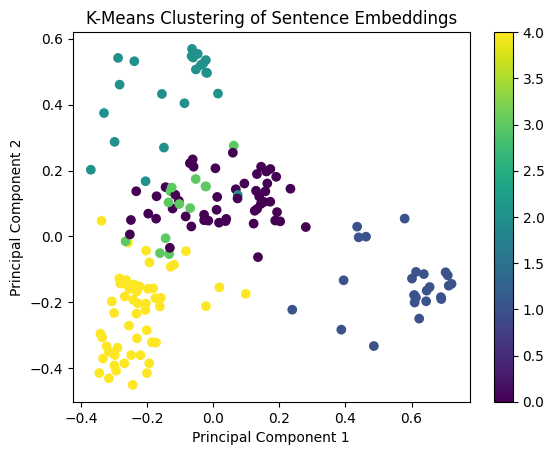

In [91]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
embeddings_2d = pca.fit_transform(embeddings)

# Plot the clusters
plt.scatter(embeddings_2d[:, 0], embeddings_2d[:, 1], c=df['cluster'], cmap='viridis')
plt.title('K-Means Clustering of Sentence Embeddings')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.colorbar()
plt.show()

Calculate the within cluster sum of squares or inertia. This is the within-cluster sum of squares. (lower = more compact, higher = more spread). Should use "elbow method" to select number of clusters: as you increase k, when the WCSS stops decreasing choose that number of clusters (i.e., smallest number of clusters with smallest WCSS score).

In [92]:
wcss = kmeans.inertia_
print(wcss)

94.99539184570312


Decode/find closest examples to centroid centers. Right now we're just using cosine similarity, but I think there are ways to use generative models to create understandable representations of the sentence embeddings.

In [93]:
# get embedding vectors of centroids
centroid_embeddings = kmeans.cluster_centers_

def get_closest_sentence(query_embedding, corpus, corpus_embeddings):
    similarity_scores  = util.cos_sim(query_embedding, corpus_embeddings) 
    closest_sentence = corpus[similarity_scores.argmax()]
    return closest_sentence

In [109]:
corpus = df["answer"]
for i, centroid_vec in enumerate(centroid_embeddings):
    similarity_scores = util.cos_sim(centroid_vec, embeddings)
    print(similarity_scores)
    print(similarity_scores.argmax())
    closest_sentence = corpus[int(similarity_scores.argmax())]
    print(f"Center sentence of cluster {i}:\n-----\n{closest_sentence}\n-----\n\n")

tensor([[ 0.4532,  0.6324,  0.3302,  0.4903,  0.3017,  0.3563,  0.6087,  0.6101,
          0.5920,  0.4287,  0.4202,  0.2780,  0.3650,  0.2500,  0.6484,  0.3321,
          0.4680,  0.2997,  0.4420,  0.4075,  0.4893,  0.5826,  0.7489,  0.4080,
          0.5382,  0.3623,  0.4050,  0.3365,  0.2841,  0.3229,  0.0522,  0.4115,
          0.7313,  0.4204,  0.3016,  0.6448,  0.2624,  0.1449,  0.3454,  0.6792,
          0.3361,  0.4072,  0.4929,  0.1735,  0.1290,  0.4122,  0.7221,  0.4241,
          0.5139,  0.2833,  0.4188,  0.6018,  0.4198,  0.3624,  0.3567,  0.2816,
          0.5149,  0.6247,  0.4896,  0.3406,  0.4918,  0.5583,  0.6263,  0.5441,
          0.0420,  0.5069,  0.5719,  0.4392,  0.6612,  0.4225,  0.3985,  0.5053,
          0.4649,  0.5693,  0.5239,  0.4487,  0.5373,  0.5909,  0.3730,  0.2433,
          0.6454,  0.3220,  0.4579,  0.2107,  0.2679,  0.1409,  0.5603,  0.6017,
          0.4097,  0.5539,  0.4767,  0.4148,  0.4429,  0.3677,  0.0724,  0.4344,
          0.6749,  0.6607,  

KeyError: 69

## Now let's incorporate decision tree feature importances

"Shrink" the non-important features w.r.t. the output you care about, and "Expand" the important ones, i.e., the ones whose values determines the output class.

In [110]:
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import accuracy_score

# choose an output class we care about
output_class = "priority"
X_train, X_test, y_train, y_test = train_test_split(embeddings, df[output_class], random_state = 8, test_size = 0.3)


Train the Decision tree, find dfeature importances

In [112]:
# Fit your decision tree model
model = DecisionTreeClassifier()
model.fit(X_train, y_train)

# Access feature importances
feature_importances = model.feature_importances_


In [130]:
# Calculate the accuracy BEFORE flooring
y_pred = model.predict(X_test)
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy} for class amounts:\n {df[output_class].value_counts()}")

Accuracy: 0.3469387755102041 for class amounts:
 priority
high      73
medium    53
low       37
Name: count, dtype: int64


Get rid features indices that are 0.

In [131]:
import numpy as np
# Get indices of zero-importance features
zero_importance_indices = np.where(feature_importances == 0)[0]

# delete those entries
embeddings_small = np.delete(embeddings, zero_importance_indices, axis=1)
X_train_reduced = np.delete(X_train, zero_importance_indices, axis=1)
X_test_reduced = np.delete(X_test, zero_importance_indices, axis=1)
print(f"embedding went from size {len(X_train[0])} to {len(X_train_reduced[0])}")

embedding went from size 384 to 20


Retrain classifier on just this

In [132]:
# Fit your decision tree model
model_small = DecisionTreeClassifier()
model_small.fit(X_train_reduced, y_train)

# Access feature importances
#feature_importances = model.feature_importances_

# Calculate the accuracy after deleting
y_pred_smaller = model_small.predict(X_test_reduced)
accuracy = accuracy_score(y_test, y_pred_smaller)
print(f"Accuracy: {accuracy} for class amounts:\n {df[output_class].value_counts()}")

Accuracy: 0.3673469387755102 for class amounts:
 priority
high      73
medium    53
low       37
Name: count, dtype: int64


## Same clustering process but on only important features

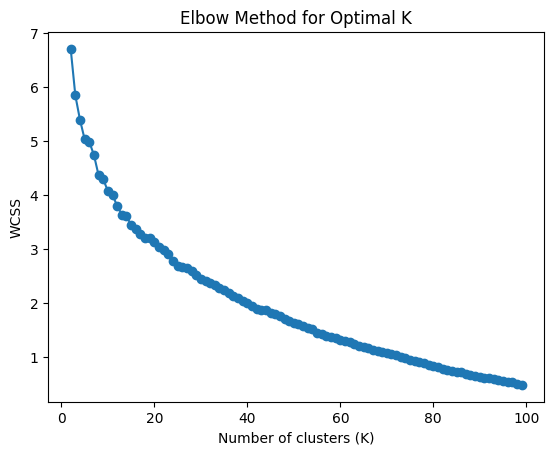

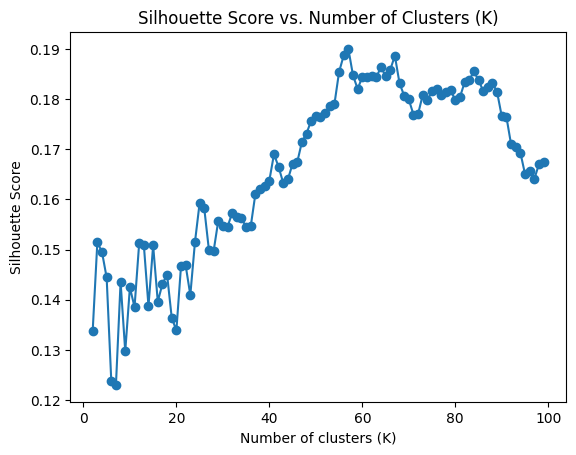

In [133]:
# determine numm clusters by WCSS and silhouette_score (needed for highly dimensional data)
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
from sklearn.metrics import silhouette_score


# Initialize variables
wcss = []
silhouette_scores = []
upper_bound_k = 100
# Calculate WCSS for each K
for k in range(2, upper_bound_k):  # Choosing range from 1 to 10 for demonstration
    # wcss
    kmeans = KMeans(n_clusters=k, random_state=0)
    kmeans.fit(embeddings_small)  # Assuming X is your dataset
    wcss.append(kmeans.inertia_)
    
    labels = kmeans.fit_predict(embeddings_small)
    score = silhouette_score(embeddings_small, labels)
    silhouette_scores.append(score)

# Plot the WCSS values
plt.plot(range(2, upper_bound_k), wcss, marker='o')
plt.title('Elbow Method for Optimal K')
plt.xlabel('Number of clusters (K)')
plt.ylabel('WCSS')
plt.show()

# Plot silhouette scores to find optimal K
plt.plot(range(2, upper_bound_k), silhouette_scores, marker='o')
plt.title('Silhouette Score vs. Number of Clusters (K)')
plt.xlabel('Number of clusters (K)')
plt.ylabel('Silhouette Score')
plt.show()

In [141]:
num_clusters = 10  # Define the number of clusters you want
kmeans = KMeans(n_clusters=num_clusters, random_state=42)
df['cluster_small-e'] = kmeans.fit_predict(embeddings_small)

In [142]:
print("Sentence Clustering:")
for i in range(num_clusters):
    print(f"\n\n\nCluster {i}:")
    samples = df[df['cluster_small-e'] == i]['answer'].tolist()[:4]
    for s in samples:
        print("--")
        print(s)
    print("--")

Sentence Clustering:



Cluster 0:
--
Dear <name>, 

Thank you for your message. We're sorry for the inconvenience. Please check for firmware updates, overheating issues, and hardware faults. Contact our support at <tel_num> for further assistance.

Best regards,
Customer Support
--
Dear <name>,

Thank you for contacting us. We are sorry to hear about the issue with your Samsung QN90A. Please return the product to our returns department. Ensure to include your account number <acc_num> in the package. Our address and further instructions will be sent via email.

Best,
Tech Online Store Support
--
Dear <name>,

Thank you for reaching out. We're sorry to hear about the screen flickering issue with your Microsoft Surface Pro 7. Please visit our service center website and book an appointment for a repair or replacement. If you need further assistance, don't hesitate to reply to this email.

Best regards,
Customer Support
--
Please restart your TV and update firmware. If issue persists, cont